In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd
import copy
import random
import warnings
warnings.filterwarnings("ignore")

In [ ]:
SEED = 1337
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)


In [ ]:
def make_moons_manual(n_samples=500, noise=0.2, seed=1337):

    rng = np.random.RandomState(seed)
    n = n_samples
    n_half = n // 2

    t1 = rng.uniform(0, np.pi, n_half)
    t2 = rng.uniform(0, np.pi, n - n_half)

    x1 = np.vstack([np.cos(t1), np.sin(t1)]).T

    x2 = np.vstack([1 - np.cos(t2), -np.sin(t2) - 0.5]).T
    # stack and add gaussian noise
    X = np.vstack([x1, x2]) + rng.normal(scale=noise, size=(n, 2))
    y = np.hstack([np.zeros(n_half, dtype=int), np.ones(n - n_half, dtype=int)])
    # shuffle dataset deterministically
    perm = rng.permutation(n)
    return X[perm], y[perm]

In [ ]:

X_train_all, y_train_all = make_moons_manual(n_samples=500, noise=0.2, seed=SEED)
X_test_20, y_test_20 = make_moons_manual(n_samples=500, noise=0.2, seed=SEED+1)
X_test_10, y_test_10 = make_moons_manual(n_samples=500, noise=0.1, seed=SEED+2)
X_test_30, y_test_30 = make_moons_manual(n_samples=500, noise=0.3, seed=SEED+3)

In [ ]:

scaler = StandardScaler().fit(X_train_all)
X_train_all_std = scaler.transform(X_train_all)
X_test_20_std = scaler.transform(X_test_20)
X_test_10_std = scaler.transform(X_test_10)
X_test_30_std = scaler.transform(X_test_30)



In [ ]:

X_train, X_val, y_train, y_val = train_test_split(
    X_train_all_std, y_train_all, test_size=0.20, stratify=y_train_all, random_state=SEED
)



In [ ]:

def to_tensor(x, y=None, device='cpu'):
    x_t = torch.tensor(x, dtype=torch.float32, device=device)
    if y is None:
        return x_t
    y_t = torch.tensor(y, dtype=torch.float32, device=device).unsqueeze(1)
    return x_t, y_t

In [ ]:
class MLP(nn.Module):

    def __init__(self, hidden_dim=32):
        super().__init__()
        self.fc1 = nn.Linear(2, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        h = self.relu(self.fc1(x))
        out = self.fc2(h)
        return out

def count_parameters(model):

    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def layerwise_sparsity(model, threshold=1e-5):

    spars = {}
    for name, p in model.named_parameters():
        if p.requires_grad and (p.dim() >= 2 or ('weight' in name)):
            arr = p.detach().cpu().numpy()
            spars[name] = float((np.abs(arr) <= threshold).sum()) / arr.size
    return spars

def train_model(
    model, X_tr, y_tr, X_val, y_val,
    lr=1e-3, batch_size=64, max_epochs=2000,
    l1_lambda=0.0, l2_lambda=0.0, patience=50, device='cpu'
):

    model = copy.deepcopy(model).to(device)
    criterion = nn.BCEWithLogitsLoss()

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2_lambda)

    X_tr_t, y_tr_t = to_tensor(X_tr, y_tr, device=device)
    X_val_t, y_val_t = to_tensor(X_val, y_val, device=device)
    n = X_tr.shape[0]
    best_state = copy.deepcopy(model.state_dict())
    best_val_auc = -np.inf
    no_improve = 0

    for epoch in range(max_epochs):
        model.train()
        # simple stochastic batches
        perm = np.random.permutation(n)
        for i in range(0, n, batch_size):
            idx = perm[i:i+batch_size]
            xb = X_tr_t[idx]
            yb = y_tr_t[idx]
            logits = model(xb)
            loss = criterion(logits, yb)

            if l1_lambda > 0:
                l1 = 0.0
                for name, p in model.named_parameters():
                    if p.requires_grad and 'weight' in name:
                        l1 = l1 + p.abs().sum()
                loss = loss + l1_lambda * l1
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # validation evaluation at end of epoch (AUROC)
        model.eval()
        with torch.no_grad():
            val_logits = model(X_val_t).cpu().numpy().ravel()
            val_probs = 1 / (1 + np.exp(-val_logits))

            try:
                val_auc = roc_auc_score(y_val, val_probs)
            except ValueError:
                val_auc = 0.5
        # early stopping bookkeeping
        if val_auc > best_val_auc + 1e-9:
            best_val_auc = val_auc
            best_state = copy.deepcopy(model.state_dict())
            no_improve = 0
        else:
            no_improve += 1
        if no_improve >= patience:
            break

    # restore best params
    model.load_state_dict(best_state)
    return model, best_val_auc

def evaluate_model(model, X, y):

    model.eval()
    X_t = to_tensor(X)
    with torch.no_grad():
        logits = model(X_t).cpu().numpy().ravel()
        probs = 1 / (1 + np.exp(-logits))
        preds = (probs >= 0.5).astype(int)
    acc = accuracy_score(y, preds)
    auc = roc_auc_score(y, probs)
    return acc, auc, probs

In [ ]:

HIDDEN = 32
LR = 1e-3
BATCH = 64
PATIENCE = 50
DEVICE = 'cpu'
print("Hyperparameters set:")
print("Hidden units:", HIDDEN)
print("Learning rate:", LR)

Hyperparameters set:
Hidden units: 32
Learning rate: 0.001


In [ ]:

mlp_base = MLP(hidden_dim=HIDDEN)
mlp_es, val_auc_es = train_model(mlp_base, X_train, y_train, X_val, y_val,
                                 lr=LR, batch_size=BATCH, patience=PATIENCE,
                                 l1_lambda=0.0, l2_lambda=0.0, device=DEVICE)
params_mlp_es = count_parameters(mlp_es)
print("MLP Base Trained")
print("Parameters:", params_mlp_es)
print("Validation AUROC:", val_auc_es)

MLP Base Trained
Parameters: 129
Validation AUROC: 1.0


In [ ]:
l1_grid = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4]
l1_results = []
for lam in l1_grid:
    model = MLP(hidden_dim=HIDDEN)
    trained, val_auc = train_model(model, X_train, y_train, X_val, y_val,
                                   lr=LR, batch_size=BATCH, patience=PATIENCE,
                                   l1_lambda=lam, l2_lambda=0.0, device=DEVICE)
    spars = layerwise_sparsity(trained, threshold=1e-5)
    pcount = count_parameters(trained)
    l1_results.append((lam, trained, val_auc, spars, pcount))

In [ ]:
# record validation AUROCs for the L1 grid so we can plot Val AUROC vs lambda
l1_lambdas = [r[0] for r in l1_results]
l1_val_aucs = [r[2] for r in l1_results]

In [ ]:
# pick best L1 model by validation AUROC
best_l1_entry = max(l1_results, key=lambda t: t[2])
best_l1_lambda, mlp_l1, val_auc_l1, sparsity_l1_best, params_mlp_l1 = best_l1_entry

In [ ]:

l2_grid = [0.0, 1e-6, 1e-5, 1e-4, 1e-3]
l2_results = []
for wdec in l2_grid:
    model = MLP(hidden_dim=HIDDEN)
    trained, val_auc = train_model(model, X_train, y_train, X_val, y_val,
                                   lr=LR, batch_size=BATCH, patience=PATIENCE,
                                   l1_lambda=0.0, l2_lambda=wdec, device=DEVICE)
    pcount = count_parameters(trained)
    l2_results.append((wdec, trained, val_auc, pcount))

In [ ]:
# pick best L2 by validation AUROC
best_l2_entry = max(l2_results, key=lambda t: t[2])
best_l2_lambda, mlp_l2, val_auc_l2, params_mlp_l2 = best_l2_entry

In [ ]:

poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)

logreg = LogisticRegression(max_iter=10000, solver='lbfgs')
logreg.fit(X_train_poly, y_train)
# count logistic parameters: coefficients + intercept
params_logreg = logreg.coef_.size + logreg.intercept_.size
print("Logistic Regression trained")
print("Poly degree:", 3)
print("Logistic params:", params_logreg)


Logistic Regression trained
Poly degree: 3
Logistic params: 10


In [ ]:

def eval_all_models_on(X_test_std, y_test):

    results = {}
    # MLP ES
    acc, auc, _ = evaluate_model(mlp_es, X_test_std, y_test)
    results['MLP_EarlyStop'] = (acc, auc, params_mlp_es)
    # MLP L1 (best)
    acc, auc, _ = evaluate_model(mlp_l1, X_test_std, y_test)
    results[f'MLP_L1_λ={best_l1_lambda}'] = (acc, auc, params_mlp_l1)
    # MLP L2 (best)
    acc, auc, _ = evaluate_model(mlp_l2, X_test_std, y_test)
    results[f'MLP_L2_wdec={best_l2_lambda}'] = (acc, auc, params_mlp_l2)
    # Logistic poly
    probs_log = logreg.predict_proba(poly.transform(X_test_std))[:,1]
    preds_log = (probs_log >= 0.5).astype(int)
    acc_log = accuracy_score(y_test, preds_log)
    auc_log = roc_auc_score(y_test, probs_log)
    results['Logistic_Poly'] = (acc_log, auc_log, params_logreg)
    return results




In [ ]:
res_20 = eval_all_models_on(X_test_20_std, y_test_20)
res_10 = eval_all_models_on(X_test_10_std, y_test_10)
res_30 = eval_all_models_on(X_test_30_std, y_test_30)
print(" Evaluation complete on noise = 0.1, 0.2, 0.3")
display(res_20)
display(res_10)
display(res_30)

 Evaluation complete on noise = 0.1, 0.2, 0.3


{'MLP_EarlyStop': (0.976, np.float64(0.998096), 129),
 'MLP_L1_λ=1e-06': (0.964, np.float64(0.997136), 129),
 'MLP_L2_wdec=0.0': (0.976, np.float64(0.9992319999999999), 129),
 'Logistic_Poly': (0.998, np.float64(0.999952), 10)}

{'MLP_EarlyStop': (0.992, np.float64(0.999856), 129),
 'MLP_L1_λ=1e-06': (0.994, np.float64(0.9998239999999999), 129),
 'MLP_L2_wdec=0.0': (0.986, np.float64(0.999872), 129),
 'Logistic_Poly': (1.0, np.float64(1.0), 10)}

{'MLP_EarlyStop': (0.978, np.float64(0.998976), 129),
 'MLP_L1_λ=1e-06': (0.976, np.float64(0.998256), 129),
 'MLP_L2_wdec=0.0': (0.978, np.float64(0.9976800000000001), 129),
 'Logistic_Poly': (1.0, np.float64(1.0), 10)}

In [ ]:

model_keys = list(res_20.keys())

rows = []
for k in model_keys:
    acc20, auc20, params20 = res_20[k]
    acc10, auc10, params10 = res_10[k]
    acc30, auc30, params30 = res_30[k]

    rows.append({
        'Model': k,
        'Params': params20,
        'Acc_noise_0.10': round(acc10, 4),
        'AUROC_noise_0.10': round(auc10, 4),
        'Acc_noise_0.20': round(acc20, 4),
        'AUROC_noise_0.20': round(auc20, 4),
        'Acc_noise_0.30': round(acc30, 4),
        'AUROC_noise_0.30': round(auc30, 4),
    })

summary_df = pd.DataFrame(rows).set_index('Model')
print("=== Test accuracy and AUROC table (rows: models; columns: noise levels) ===")
display(summary_df)

=== Test accuracy and AUROC table (rows: models; columns: noise levels) ===


,Params,Acc_noise_0.10,AUROC_noise_0.10,Acc_noise_0.20,AUROC_noise_0.20,Acc_noise_0.30,AUROC_noise_0.30
Model,,,,,,,
MLP_EarlyStop,129,0.992,0.9999,0.976,0.9981,0.978,0.9990
MLP_L1_λ=1e-06,129,0.994,0.9998,0.964,0.9971,0.976,0.9983
MLP_L2_wdec=0.0,129,0.986,0.9999,0.976,0.9992,0.978,0.9977
Logistic_Poly,10,1.000,1.0000,0.998,1.0000,1.000,1.0000


In [ ]:

xx_min, xx_max = -3.0, 3.0
yy_min, yy_max = -3.0, 3.0
xx, yy = np.meshgrid(np.linspace(xx_min, xx_max, 300), np.linspace(yy_min, yy_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]

def model_probs_on_grid(model_name, grid_points):

    if model_name == 'MLP_EarlyStop':
        _, _, probs = evaluate_model(mlp_es, grid_points, np.zeros(grid_points.shape[0]))
        return probs
    elif model_name.startswith('MLP_L1'):
        _, _, probs = evaluate_model(mlp_l1, grid_points, np.zeros(grid_points.shape[0]))
        return probs
    elif model_name.startswith('MLP_L2'):
        _, _, probs = evaluate_model(mlp_l2, grid_points, np.zeros(grid_points.shape[0]))
        return probs
    elif model_name == 'Logistic_Poly':
        probs = logreg.predict_proba(poly.transform(grid_points))[:,1]
        return probs
    else:
        raise ValueError("Unknown model name for plotting")

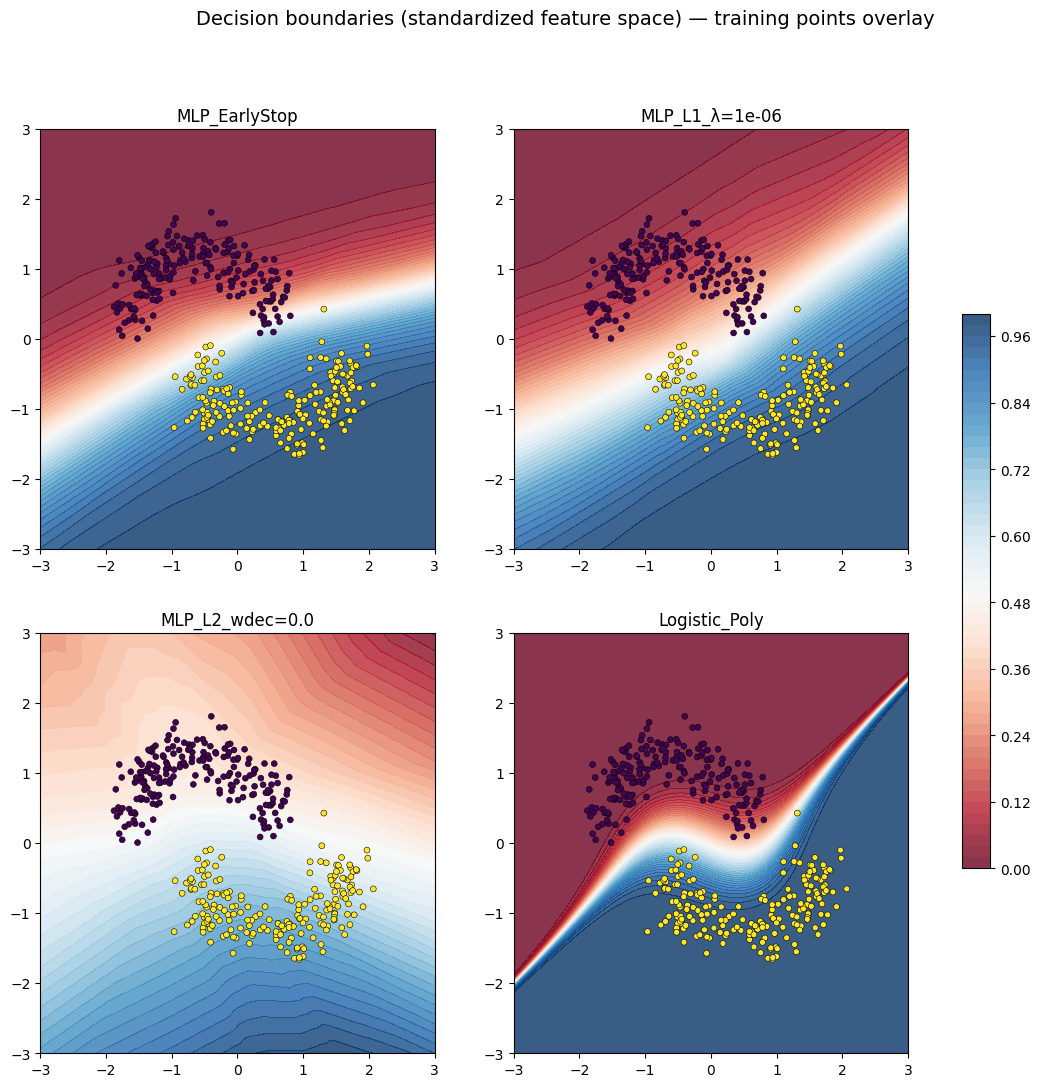

In [ ]:
# plot 2x2
fig, axes = plt.subplots(2,2, figsize=(14,12))
axes = axes.ravel()
for i, model_name in enumerate(model_keys):
    probs = model_probs_on_grid(model_name, grid)
    Z = probs.reshape(xx.shape)
    ax = axes[i]
    cs = ax.contourf(xx, yy, Z, levels=50, cmap='RdBu', alpha=0.8)
    # overlay standardized training points (from X_train)
    ax.scatter(X_train[:,0], X_train[:,1], c=y_train, s=18, edgecolor='k', linewidth=0.4)
    ax.set_title(model_name)
    ax.set_xlim(xx_min, xx_max)
    ax.set_ylim(yy_min, yy_max)
fig.colorbar(cs, ax=axes.tolist(), shrink=0.6)
plt.suptitle("Decision boundaries (standardized feature space) — training points overlay", fontsize=14)
plt.show()

In [ ]:

spars_rows = []
for lam, mdl, val_auc, spars_dict, pcount in l1_results:

    row = {'lambda': lam, 'val_auc': val_auc, 'params': pcount}
    # include each param sparsity in columns (if absent set NaN)
    for nm, sp in spars_dict.items():
        row[nm] = sp
    spars_rows.append(row)
spars_df = pd.DataFrame(spars_rows).sort_values(by='lambda').set_index('lambda')
print("=== L1 grid: layerwise sparsity (fraction of weights |w| <= 1e-5) and validation AUROC ===")
display(spars_df)


=== L1 grid: layerwise sparsity (fraction of weights |w| <= 1e-5) and validation AUROC ===


,val_auc,params,fc1.weight,fc2.weight
lambda,,,,
0.000001,1.0,129,0.0,0.00000
0.000003,1.0,129,0.0,0.00000
0.000010,1.0,129,0.0,0.00000
0.000030,1.0,129,0.0,0.00000
0.000100,1.0,129,0.0,0.03125
0.000300,1.0,129,0.0,0.00000


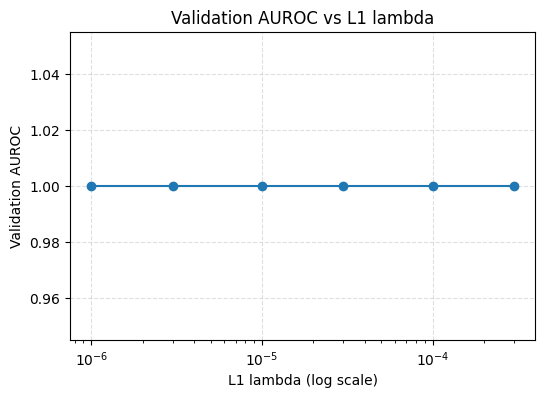

In [ ]:
# Plot validation AUROC vs lambda (log x-axis)
plt.figure(figsize=(6,4))
plt.plot(l1_lambdas, l1_val_aucs, marker='o')
plt.xscale('log')
plt.xlabel('L1 lambda (log scale)')
plt.ylabel('Validation AUROC')
plt.title('Validation AUROC vs L1 lambda')
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

In [ ]:

l2_rows = []
for wdec, mdl, val_auc, pcount in l2_results:
    l2_rows.append({'l2': wdec, 'val_auc': val_auc, 'params': pcount})
l2_df = pd.DataFrame(l2_rows).set_index('l2').sort_index()
print("=== L2 tuning results (validation AUROC) ===")
display(l2_df)
print(f"Best L2 weight decay selected: {best_l2_lambda} with val AUROC {val_auc_l2:.4f}")


=== L2 tuning results (validation AUROC) ===


,val_auc,params
l2,,
0.000000,1.0,129
0.000001,1.0,129
0.000010,1.0,129
0.000100,1.0,129
0.001000,1.0,129


Best L2 weight decay selected: 0.0 with val AUROC 1.0000


In [ ]:
#Class-imbalance experiment:
def make_imbalanced_train(X_full_std, y_full, desired_ratio=0.7, total_size=500, seed=SEED+42):

    rng = np.random.RandomState(seed)
    n_major = int(total_size * desired_ratio)
    n_minor = total_size - n_major
    # identify indices per class
    idx0 = np.where(y_full == 0)[0]
    idx1 = np.where(y_full == 1)[0]

    maj_label = 0
    min_label = 1
    if len(idx1) > len(idx0):

        maj_label, min_label = 1, 0
        idx_maj, idx_min = idx1, idx0
    else:
        idx_maj, idx_min = idx0, idx1

    maj_idx_sample = rng.choice(idx_maj, size=n_major, replace=True)
    min_idx_sample = rng.choice(idx_min, size=n_minor, replace=True)
    sel_idx = np.concatenate([maj_idx_sample, min_idx_sample])
    rng.shuffle(sel_idx)
    return X_full_std[sel_idx], y_full[sel_idx]

In [ ]:

X_train_imb, y_train_imb = make_imbalanced_train(X_train_all_std, y_train_all, desired_ratio=0.7, total_size=500, seed=SEED+99)

X_train_imb_train, X_train_imb_val, y_train_imb_train, y_train_imb_val = train_test_split(
    X_train_imb, y_train_imb, test_size=0.20, stratify=y_train_imb, random_state=SEED
)


In [ ]:

mlp_base_imb = MLP(hidden_dim=HIDDEN)
mlp_es_imb, _ = train_model(mlp_base_imb, X_train_imb_train, y_train_imb_train, X_train_imb_val, y_train_imb_val,
                            lr=LR, batch_size=BATCH, patience=PATIENCE, device=DEVICE)


In [ ]:

l1_results_imb = []
for lam in l1_grid:
    model = MLP(hidden_dim=HIDDEN)
    trained, val_auc = train_model(model, X_train_imb_train, y_train_imb_train, X_train_imb_val, y_train_imb_val,
                                   lr=LR, batch_size=BATCH, patience=PATIENCE, l1_lambda=lam, device=DEVICE)
    spars = layerwise_sparsity(trained, threshold=1e-5)
    pcount = count_parameters(trained)
    l1_results_imb.append((lam, trained, val_auc, spars, pcount))
best_l1_imb = max(l1_results_imb, key=lambda t: t[2])
best_l1_lambda_imb, mlp_l1_imb, _, spars_l1_imb, params_l1_imb = best_l1_imb


In [ ]:

l2_results_imb = []
for wdec in l2_grid:
    model = MLP(hidden_dim=HIDDEN)
    trained, val_auc = train_model(model, X_train_imb_train, y_train_imb_train, X_train_imb_val, y_train_imb_val,
                                   lr=LR, batch_size=BATCH, patience=PATIENCE, l2_lambda=wdec, device=DEVICE)
    pcount = count_parameters(trained)
    l2_results_imb.append((wdec, trained, val_auc, pcount))
best_l2_imb = max(l2_results_imb, key=lambda t: t[2])
best_l2_lambda_imb, mlp_l2_imb, _, params_l2_imb = best_l2_imb

In [ ]:
# Logistic regression on polynomial features trained on imbalanced train
poly_imb = PolynomialFeatures(degree=2, include_bias=False)
X_train_imb_poly = poly_imb.fit_transform(X_train_imb_train)
X_val_imb_poly = poly_imb.transform(X_train_imb_val)
logreg_imb = LogisticRegression(max_iter=10000, solver='lbfgs')
logreg_imb.fit(X_train_imb_poly, y_train_imb_train)
params_logreg_imb = logreg_imb.coef_.size + logreg_imb.intercept_.size

In [ ]:
# Evaluate imbalanced-trained models on original balanced tests (noise 0.1/0.2/0.3)
def eval_imb_models_on(X_test_std, y_test):
    results = {}
    # MLP ES (imb)
    acc, auc, _ = evaluate_model(mlp_es_imb, X_test_std, y_test)
    results['MLP_EarlyStop_imb'] = (acc, auc, count_parameters(mlp_es_imb))
    # MLP L1 (imb)
    acc, auc, _ = evaluate_model(mlp_l1_imb, X_test_std, y_test)
    results[f'MLP_L1_imb_λ={best_l1_lambda_imb}'] = (acc, auc, count_parameters(mlp_l1_imb))
    # MLP L2 (imb)
    acc, auc, _ = evaluate_model(mlp_l2_imb, X_test_std, y_test)
    results[f'MLP_L2_imb_wdec={best_l2_lambda_imb}'] = (acc, auc, count_parameters(mlp_l2_imb))
    # logistic (imb)
    probs_log = logreg_imb.predict_proba(poly_imb.transform(X_test_std))[:,1]
    preds_log = (probs_log >= 0.5).astype(int)
    results['Logistic_Poly_imb'] = (accuracy_score(y_test, preds_log), roc_auc_score(y_test, probs_log), params_logreg_imb)
    return results

res_20_imb = eval_imb_models_on(X_test_20_std, y_test_20)
res_10_imb = eval_imb_models_on(X_test_10_std, y_test_10)
res_30_imb = eval_imb_models_on(X_test_30_std, y_test_30)

In [ ]:
# Build DataFrame summarizing imbalance experiment
rows_imb = []
for k in res_20_imb.keys():
    a20, auc20, p20 = res_20_imb[k]
    a10, auc10, p10 = res_10_imb[k]
    a30, auc30, p30 = res_30_imb[k]
    rows_imb.append({
        'Model': k,
        'Params': p20,
        'Acc_noise_0.10': round(a10, 4),
        'AUROC_noise_0.10': round(auc10, 4),
        'Acc_noise_0.20': round(a20, 4),
        'AUROC_noise_0.20': round(auc20, 4),
        'Acc_noise_0.30': round(a30, 4),
        'AUROC_noise_0.30': round(auc30, 4),
    })
summary_imb_df = pd.DataFrame(rows_imb).set_index('Model')

print("=== Imbalanced-train experiment: performance on balanced test sets ===")
display(summary_imb_df)

=== Imbalanced-train experiment: performance on balanced test sets ===


,Params,Acc_noise_0.10,AUROC_noise_0.10,Acc_noise_0.20,AUROC_noise_0.20,Acc_noise_0.30,AUROC_noise_0.30
Model,,,,,,,
MLP_EarlyStop_imb,129,0.928,0.9994,0.916,0.9959,0.928,0.9976
MLP_L1_imb_λ=1e-06,129,0.500,0.9998,0.500,0.9980,0.500,0.9980
MLP_L2_imb_wdec=0.0,129,0.660,0.9996,0.662,0.9957,0.680,0.9971
Logistic_Poly_imb,6,1.000,1.0000,0.992,0.9995,0.992,0.9999


In [ ]:

print("\n=== Selected hyperparameters and best models (from validation) ===")
print(f"MLP EarlyStop params: {params_mlp_es}, val AUROC (base) {val_auc_es:.4f}")
print(f"Best L1 lambda: {best_l1_lambda}, val AUROC {val_auc_l1:.4f}, params {params_mlp_l1}")
print("L1 layerwise sparsity for best lambda (threshold 1e-5):")
for k,v in sparsity_l1_best.items():
    print(f"  {k}: {v*100:.2f}% zeros (|w| <= 1e-5)")
print(f"Best L2 weight decay: {best_l2_lambda}, val AUROC {val_auc_l2:.4f}, params {params_mlp_l2}")
print(f"Logistic (poly deg2) params: {params_logreg}")

# Show the L1 sparsity dataframe again for emphasis
print("\nL1 grid results (sparsity & val AUROC):")
display(spars_df)

print("\nCode run complete — tables and figures above show requested results.")


=== Selected hyperparameters and best models (from validation) ===
MLP EarlyStop params: 129, val AUROC (base) 1.0000
Best L1 lambda: 1e-06, val AUROC 1.0000, params 129
L1 layerwise sparsity for best lambda (threshold 1e-5):
  fc1.weight: 0.00% zeros (|w| <= 1e-5)
  fc2.weight: 0.00% zeros (|w| <= 1e-5)
Best L2 weight decay: 0.0, val AUROC 1.0000, params 129
Logistic (poly deg2) params: 10

L1 grid results (sparsity & val AUROC):


,val_auc,params,fc1.weight,fc2.weight
lambda,,,,
0.000001,1.0,129,0.0,0.00000
0.000003,1.0,129,0.0,0.00000
0.000010,1.0,129,0.0,0.00000
0.000030,1.0,129,0.0,0.00000
0.000100,1.0,129,0.0,0.03125
0.000300,1.0,129,0.0,0.00000



Code run complete — tables and figures above show requested results.
